# Project 1: Regression analysis and resampling methods

## 1.a: Ordinary Least Square on the Franke function with resampling

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import seaborn as sns
%matplotlib inline

First we can generate our own dataset for the function, with added noise, and plot the result

(20, 20)

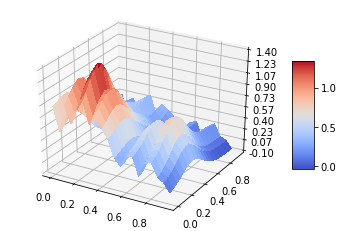

In [2]:


# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
X, Y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


Z = FrankeFunction(X, Y) + 0.15*np.random.randn(len(x)) # with added random noise
Z_nn = FrankeFunction(X, Y) # without noise

# Plot the surface.

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
Z.shape

Then we need to perform a standard least square regression analysis using polynomials in x and y up to fifth order. We can use the numpy.polynomial-function polyvander2d to set up a design matrix. The vector of estimated polynomial regression coefficients is then given by:

$$\hat{\beta} = (\textbf{X}^T \textbf{X})^{-1} \textbf{X}^T \hat{y}$$

We can use the singular value decomposition module numpy.linalg.svd, we can write the matrix $\textbf{X}^T \textbf{X}^{-1} = U\Sigma V^T$, which has an inverse (if not singular) $V \Sigma^{-1} U^T$, and if singular:

$$(U \Sigma V^T)^{-1} \approx V \Sigma_0^{-1} U^T$$

where

$$\Sigma_0^{-1} = 1/\sigma_i \quad \text{if} \quad \sigma_i > t \qquad 0 \quad\text{otherwise}$$

where $t$ is a small threshold

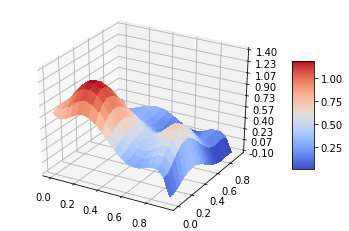

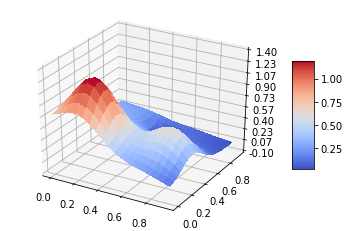

In [3]:
# make the mesh points one-dimensional as x1, y1, x2, y2, instead of [x1, y1], [x2, y2]
X_f = X.flatten()
Y_f = Y.flatten()
Z_f = Z.flatten() 

deg = 5
# create the design matrix
A = np.polynomial.polynomial.polyvander2d(X_f, Y_f, [deg, deg])


def OSL(z, X):
    """
    z: data points
    X: design matrix
    """
    
    mat = np.linalg.inv(np.dot(X.T, X))
    return np.dot(mat, np.dot(X.T, z))

def get_index(beta, deg):
    beta_proper = np.zeros((deg, deg))
    
    counter = 0
    for i in range(deg):
        for j in range(deg):
            beta_proper[i][j] = beta[counter]
            counter += 1
    return beta_proper

beta_OSL = OSL(Z_f, A)

z_tilde = A @ beta_OSL # make the prediction


# plotting

beta_proper = get_index(beta_OSL, deg+1) # betas indexed properly
z_model_plot = np.polynomial.polynomial.polyval2d(X, Y, beta_proper)


fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, z_model_plot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z_nn, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


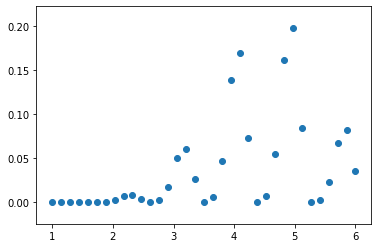

In [4]:
from sklearn.linear_model import LinearRegression


def test_OSL(X, Z, beta_OSL):
    """Testing the difference between the analytical parameters vs
        the estimated betas from scikit-learn's linear regression model"""
    
    lin_model = LinearRegression(fit_intercept=True)
    lin_model.fit(X, Z)
    
    coefs = lin_model.coef_
    
    diff = abs(coefs - beta_OSL)
    
    return diff

diff = test_OSL(A, Z_f, beta_OSL)
plt.scatter(np.linspace(1, 6, len(diff)-1), diff[1:])

In [5]:
def MSE(z, z_model):
    z = z.flatten()
    z_model = z_model.flatten()
    return (1/len(z))*np.sum((z - z_model)**2)

def R2(z, z_model):
    z = z.flatten()
    z_model = z_model.flatten()
    
    return 1 - (np.sum((z - z_model)**2))/np.sum((z - np.mean(z))**2)

R2_score = R2(Z, z_tilde)
MSE_score = MSE(Z, z_tilde)

print("R2 score: {}" .format(R2_score))
print("MSE score: {}" .format(MSE_score))

R2 score: 0.8556258519531805
MSE score: 0.014669971278645071


## part b: resampling

- split the data in training data and test data
- implement k-fold cross-validations

'plt.figure()\nplt.plot(np.log10complexity, R2_avg[0], label="Test data")\nplt.plot(complexity, R2_avg[0], label="Training data")\nplt.xlabel("Model complexity (polynomial degree)")\nplt.ylabel("R2 score (MSE)")\nplt.xticks(complexity)\nplt.legend()'

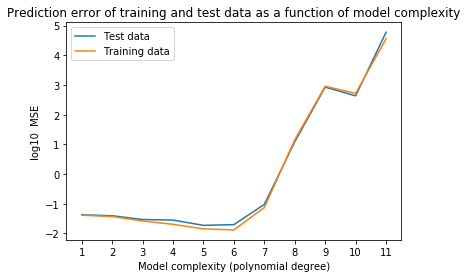

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

np.random.seed(2212)

def simple_resampling(X, Z):
    """A function for performing a simple resampling of the data by
       splitting into training and testing
       A: design matrix, Z: target data"""
    
    X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.2)
    betas = OSL(Z_train, X_train)
    
    Z_pred_train = X_train @ betas
    print("Training R2")
    print(R2(Z_train, Z_pred_train))
    print("Training MSE")
    print(MSE(Z_train, Z_pred_train))
    Z_pred_test = X_test @ betas
    print("Test R2")
    print(R2(Z_test, Z_pred_test))
    print("Test MSE")
    print(MSE(Z_test, Z_pred_test))
    
    
    #print("MSE score with resampling: {}" .format(MSE_score))
    #print("R2 score with resampling: {}" .format(R2_score))
    
    
#simple_resampling(A, Z_f)
    

    


def kfold_cv(Z, deg, K):
    """
    Z: target data
    deg: degree of polynomial
    Cross-validation with OLS regression
    K: number of CV folds
    
    """
    # create the design matrix
    X = np.polynomial.polynomial.polyvander2d(X_f, Y_f, [deg, deg])
    
    # for storing the sum of the MSE and R2-scores. index 0: test data, index 1: training data
    R2_avg = np.zeros(2)  
    MSE_avg = np.zeros(2)
    

    # initialize the linear model
    model = LinearRegression()
    
    # create array of indices, shuffle, and split into K lists
    idx = np.linspace(0, len(Z)-1, len(Z), dtype=np.int64)
    np.random.shuffle(idx)
    shuffled_split_idx = np.array_split(idx, K)
    

    for i in range(K):
        
        # split into test data
        X_test = X[shuffled_split_idx[i]]
        Z_test = Z[shuffled_split_idx[i]]
    

        # split into training data
        X_train = np.array([X[j] for j in idx if j not in shuffled_split_idx[i]])
        Z_train = np.array([Z[j] for j in idx if j not in shuffled_split_idx[i]])
        
        betas = OSL(Z_train, X_train)
        Z_model_train = X_train @ betas
        Z_model_test = X_test @ betas
        
        """# train the model with the training data
        model.fit(X_train, Z_train)

        # predict values using test data
        Z_model_test = model.predict(X_test)
        
        # predict values using training data
        Z_model_train = model.predict(X_train)"""

        # calculate the MSE and R2 scores and sum them
        MSE_avg[0] += MSE(Z_test, Z_model_test)
        R2_avg[0] += R2(Z_test, Z_model_test)

        MSE_avg[1] += MSE(Z_train, Z_model_train)
        R2_avg[1] += R2(Z_train, Z_model_train)
        
    #return the average MSE and R2 scores, and the model coefficients with the design matrix
    return MSE_avg/K, R2_avg/K#, model.coef_



complexity = np.arange(1, 12, 1)

MSE_avg = np.zeros((2, (len(complexity))))
R2_avg = np.copy(MSE_avg)

for i in range(len(complexity)):
    MSE_score, R2_score = kfold_cv(Z_f, complexity[i], 5)
    MSE_avg[0, i] = MSE_score[0]
    R2_avg[0, i] = R2_score[0]
    
    MSE_avg[1, i] = MSE_score[1]
    R2_avg[1, i] = R2_score[1]
    
plt.plot(complexity, np.log10(MSE_avg[0]), label="Test data")
plt.plot(complexity, np.log10(MSE_avg[1]), label="Training data")
plt.xlabel("Model complexity (polynomial degree)")
plt.ylabel("log10  MSE")
plt.xticks(complexity)
plt.title("Prediction error of training and test data as a function of model complexity")
plt.legend()

"""plt.figure()
plt.plot(np.log10complexity, R2_avg[0], label="Test data")
plt.plot(complexity, R2_avg[0], label="Training data")
plt.xlabel("Model complexity (polynomial degree)")
plt.ylabel("R2 score (MSE)")
plt.xticks(complexity)
plt.legend()"""

In [17]:
def bias_variance(n_kfold, deg):
    betas = kfold_cv(Z_f, deg, n_kfold)[-1]
    Z_model = A @ betas
    
    model_variance = np.var(Z_model)
    bias_squared = 1.0/len(Z_f)*np.sum((Z_f - np.mean(Z_model))**2)
    
    error = np.mean( np.mean((Z_f - Z_model)**2) )

    return model_variance, bias_squared, error

print(bias_variance(5, 5))


"""complexity = np.arange(1, 8, 1)

MSE_avg = np.zeros((len(complexity)))
R2_avg = np.copy(MSE_avg)
errors = np.copy(MSE_avg)
bias, variance = np.copy(MSE_avg), np.copy(MSE_avg)

for idx, deg in enumerate(complexity):
    variance[idx], bias[idx], errors[idx] = bias_variance(5, deg)
plt.plot(complexity, variance, label="Variance")
plt.plot(complexity, bias, label="Bias^2")
plt.xlabel("Model complexity (polynomial degree)")
plt.ylabel("Wtf")
plt.xticks(complexity)
plt.legend()"""

    


(206778.70670171396, 104303.7617996024, 310886.11758574756)


'complexity = np.arange(1, 8, 1)\n\nMSE_avg = np.zeros((len(complexity)))\nR2_avg = np.copy(MSE_avg)\nerrors = np.copy(MSE_avg)\nbias, variance = np.copy(MSE_avg), np.copy(MSE_avg)\n\nfor idx, deg in enumerate(complexity):\n    variance[idx], bias[idx], errors[idx] = bias_variance(5, deg)\nplt.plot(complexity, variance, label="Variance")\nplt.plot(complexity, bias, label="Bias^2")\nplt.xlabel("Model complexity (polynomial degree)")\nplt.ylabel("Wtf")\nplt.xticks(complexity)\nplt.legend()'

# Part d): Ridge Regression on the Franke function with resampling



MSE and R2 with Ridge:
MSE: 0.029867878189430673
R2: 0.7060560388524832


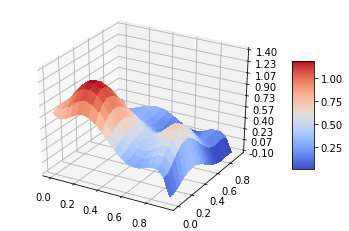

In [24]:
def beta_ridge(X, _lambda):
    y = Z_f
    mat = np.linalg.inv(np.dot(X.T, X) + _lambda*np.eye(len(X[0,:])))
    return np.dot(mat, np.dot(X.T, y))

beta_Ridge = beta_ridge(A, 0.1)
Z_tilde_ridge = A @ beta_Ridge
MSE_ridge = MSE(Z_f, Z_tilde_ridge)
R2_ridge = R2(Z_f, Z_tilde_ridge)
print("MSE and R2 with Ridge:")
print("MSE: {}" .format(MSE_ridge))
print("R2: {}" .format(R2_ridge))

# plotting
beta_Ride_proper = get_index(beta_Ridge, 5)
z_model_ridge = np.polynomial.polynomial.polyval2d(X, Y, beta_proper)
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, z_model_ridge, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


In [1]:
import scipy as scl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import seaborn as sns
%matplotlib inline

seed(2212)

def FrankeFunction(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

class FrankeFunction_analysis(object):
    def __init__(self, n, k):
        self.n = n # number of grid points
        self.k = k # noise strength
        
        self.X, self.Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))                
        
        
    def FrankeFunction(self, x, y):
        """Returns the Franke function evaluated at x and y"""
        term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
        term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
        term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
        term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
        return term1 + term2 + term3 + term4


    def make_data(self):
        
        return self.FrankeFunction(self.X, self.Y)
    
    def plot_Franke(self, noise=True):
        
        if noise:
            Z = self.FrankeFunction(self.X, self.Y) + self.k*np.random.randn(self.n)
        else:
            Z = self.FrankeFunction(self.X, self.Y)
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')

        surf = ax.plot_surface(self.X, self.Y, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)

        # Customize the z axis.
        ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=0.5, aspect=5)
        
    
    def make_designmatrix(self, X, Y, deg):
        """Returns the design matrix for a given polynomial degree"""
        return np.polynomial.polynomial.polyvander2d(X.flatten(), Y.flatten(), [deg, deg])

    def OSL(self, Z, X):
        import scipy as scl
        """
        Returns the OSL beta parameters using SVD
        Z: data points (target)
        X: design matrix
        """
        # SVD
        u, s, v = np.linalg.svd(X)
        return v.T @ np.linalg.pinv(scl.linalg.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ Z
    
    def Ridge(self, Z, X, _lambda):
        """
        Return the Ridge regression beta parameters
        Z: data points
        X: design matrix
        _lambda: hyperparameter
        """
        mat = np.linalg.inv(np.dot(X.T, X) + _lambda*np.eye(len(X[0,:])))
        return np.dot(mat, np.dot(X.T, Z))
    
    def Lasso(self, Z, X, alph):
        """Simple Lasso regression without resampling"""
        
        model = Lasso(alpha=alph)
        model.fit(X, Z)
        Z_tilde = model.predict(X)
        
        
        return Z_tilde, model.coef_
        
        
        

    def MSE(self, Z, Z_model):
        """
        Returns the Mean Squared Error
        Z: target data points
        Z_model: predicted valyes
        """
        
        return (1/len(Z))*np.sum((Z - Z_model)**2)

    def R2(self, Z, Z_model):
        """
        Returns the R2 score
        Z: target data points
        Z_model: predicted valyes
        """

        return 1 - (np.sum((Z - Z_model)**2))/np.sum((Z - np.mean(Z))**2)

    
    def simple_resampling(self, X, Z):
        """A function for performing a simple resampling of the data by
           splitting into training and testing
           A: design matrix, Z: target data"""

        # split the data and train the model on the training data
        X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.2, random_state=5)
        betas = OSL(Z_train, X_train)

        # calculate the MSE and R2 for both the training and the test data
        Z_pred_train = X_train @ betas
        print("Training R2")
        print(R2(Z_train, Z_pred_train))
        print("Training MSE")
        print(MSE(Z_train, Z_pred_train))
        
        Z_pred_test = X_test @ betas
        print("Test R2")
        print(R2(Z_test, Z_pred_test))
        print("Test MSE")
        print(MSE(Z_test, Z_pred_test))
    


    def kfold_cv(self, X, K):
        """
        Z: target data
        deg: degree of polynomial
        Cross-validation with OLS regression
        K: number of CV folds
        X: design matrix
        """

        
        # initialize data
        Z_data = self.make_data().flatten()

        # for storing the sum of the MSE and R2-scores. index 0: test data, index 1: training data
        R2_avg = np.zeros(2)  
        MSE_avg = np.zeros(2)


        # initialize the linear model
        model = LinearRegression()

        # create array of indices, shuffle, and split into K lists
        idx = np.linspace(0, len(Z_data)-1, len(Z_data), dtype=np.int64)
        np.random.shuffle(idx)
        shuffled_split_idx = np.array_split(idx, K)


        for i in range(K):

            # split into test data
            X_test = X[shuffled_split_idx[i]]
            Z_test = Z_data[shuffled_split_idx[i]]


            # split into training data
            X_train = np.array([X[j] for j in idx if j not in shuffled_split_idx[i]])
            Z_train = np.array([Z_data[j] for j in idx if j not in shuffled_split_idx[i]])

            betas = self.OSL(Z_train, X_train)
            Z_model_train = X_train @ betas
            Z_model_test = X_test @ betas

            # calculate the MSE and R2 scores and sum them
            MSE_avg[0] += self.MSE(Z_test, Z_model_test)
            R2_avg[0] += self.R2(Z_test, Z_model_test)

            MSE_avg[1] += self.MSE(Z_train, Z_model_train)
            R2_avg[1] += self.R2(Z_train, Z_model_train)

        #return the average MSE and R2 scores
        return MSE_avg/K, R2_avg/K, betas
    
    
    def kfold_cv_ridge(self, X, K, lam_max):
        """Performing K-fold cross validation with Ridge regression"""
        
        # initialize the lambdas
        _lambda = np.logspace(-5, lam_max, 100)
        
        
        # initialize data
        Z_data = self.make_data().flatten()

        # for storing the sum of the MSE and R2-scores for each lambda index 0: test data, index 1: training data
        R2_avg = np.zeros((2, len(_lambda)))  
        MSE_avg = np.zeros((2, len(_lambda)))


        # create array of indices, shuffle, and split into K lists
        idx = np.linspace(0, len(Z_data)-1, len(Z_data), dtype=np.int64)
        np.random.shuffle(idx)
        shuffled_split_idx = np.array_split(idx, K)


        for (i_l, l) in enumerate(_lambda):
            for i in range(K):

                # split into test data
                X_test = X[shuffled_split_idx[i]]
                Z_test = Z_data[shuffled_split_idx[i]]


                # split into training data
                X_train = np.array([X[j] for j in idx if j not in shuffled_split_idx[i]])
                Z_train = np.array([Z_data[j] for j in idx if j not in shuffled_split_idx[i]])

                betas = self.Ridge(Z_train, X_train, l)
                Z_model_train = X_train @ betas
                Z_model_test = X_test @ betas

                # calculate the MSE and R2 scores and sum them
                MSE_avg[0, i_l] += self.MSE(Z_test, Z_model_test)
                R2_avg[0, i_l] += self.R2(Z_test, Z_model_test)

                MSE_avg[1, i_l] += self.MSE(Z_train, Z_model_train)
                R2_avg[1, i_l] += self.R2(Z_train, Z_model_train)


            #return the average MSE and R2 scores
        return MSE_avg/K, R2_avg/K, betas
    
    def kfold_cv_lasso(self, X, K, alph_max):
        """Performing K-fold cross validation with Lasso regression"""
        
        # initialize the hyperparameters for lasso regression
        alpha = np.logspace(-5, alph_max, 100)
        

        # initialize data
        Z_data = self.make_data().flatten()

        # for storing the sum of the MSE and R2-scores for each lambda index 0: test data, index 1: training data
        R2_avg = np.zeros((2, len(alpha)))  
        MSE_avg = np.zeros((2, len(alpha)))


        # create array of indices, shuffle, and split into K lists
        idx = np.linspace(0, len(Z_data)-1, len(Z_data), dtype=np.int64)
        np.random.shuffle(idx)
        shuffled_split_idx = np.array_split(idx, K)


        for (i_l, l) in enumerate(alpha):
            for i in range(K):

                # split into test data
                X_test = X[shuffled_split_idx[i]]
                Z_test = Z_data[shuffled_split_idx[i]]


                # split into training data
                X_train = np.array([X[j] for j in idx if j not in shuffled_split_idx[i]])
                Z_train = np.array([Z_data[j] for j in idx if j not in shuffled_split_idx[i]])

                # calculate the MSE and R2 score from 
                Z_tilde_train = self.Lasso(Z_train, X_train, l)[0]
                Z_tilde_test = self.Lasso(Z_test, X_test, l)[0]

                # calculate the MSE and R2 scores and sum them
                MSE_avg[0, i_l] += self.MSE(Z_test, Z_tilde_test)
                R2_avg[0, i_l] += self.R2(Z_test, Z_tilde_test)

                MSE_avg[1, i_l] += self.MSE(Z_train, Z_tilde_train)
                R2_avg[1, i_l] += self.R2(Z_train, Z_tilde_train)


            #return the average MSE and R2 scores
        return MSE_avg/K, R2_avg/K

    def bias_variance(self, Z_data, deg, K):
        X = self.make_designmatrix(deg)
     
        betas = self.kfold_cv(deg, K)[-1]
        
        Z_model = X @ betas

        model_variance = np.mean(np.var(Z_model))
        #bias_squared = 1.0/len(Z_data)*np.sum((Z_data - np.mean(Z_model))**2)

        bias_squared = np.mean( (Z_data - np.mean(Z_model))**2 )
        error = np.mean( (Z_data - np.mean(Z_model))**2)

        return model_variance, bias_squared, error
    

"""testing = FrankeFunction_analysis(20, 0.15)
Z_data = testing.make_data().flatten()
X = testing.make_designmatrix(5)

beta_OSL_test = testing.OSL(Z_data, X)

z_tilde = X @ beta_OSL_test # make the prediction

R2_score = testing.R2(Z_data, z_tilde)
MSE_score = testing.MSE(Z_data, z_tilde)

print("R2 score: {}" .format(R2_score))
print("MSE score: {}" .format(MSE_score))"""

'testing = FrankeFunction_analysis(20, 0.15)\nZ_data = testing.make_data().flatten()\nX = testing.make_designmatrix(5)\n\nbeta_OSL_test = testing.OSL(Z_data, X)\n\nz_tilde = X @ beta_OSL_test # make the prediction\n\nR2_score = testing.R2(Z_data, z_tilde)\nMSE_score = testing.MSE(Z_data, z_tilde)\n\nprint("R2 score: {}" .format(R2_score))\nprint("MSE score: {}" .format(MSE_score))'

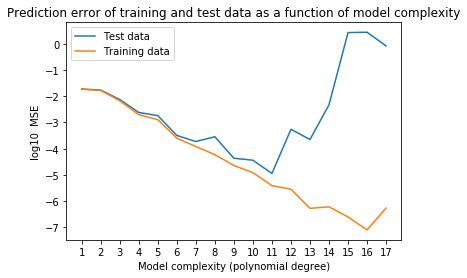

In [2]:
# analysing OLS MSE for training and testing data for higher model complexity

regression = FrankeFunction_analysis(20, 0.15)

complexity = np.arange(1, 18, 1)

MSE_avg = np.zeros((2, (len(complexity))))
R2_avg = np.copy(MSE_avg)

for i in range(len(complexity)):
    X = regression.make_designmatrix(complexity[i])
    MSE_score, R2_score = regression.kfold_cv(X, 5)[0:-1]
    MSE_avg[0, i] = MSE_score[0]
    R2_avg[0, i] = R2_score[0]

    MSE_avg[1, i] = MSE_score[1]
    R2_avg[1, i] = R2_score[1]

plt.plot(complexity, np.log10(MSE_avg[0]), label="Test data")
plt.plot(complexity, np.log10(MSE_avg[1]), label="Training data")
plt.xlabel("Model complexity (polynomial degree)")
plt.ylabel("log10  MSE")
plt.xticks(complexity)
plt.title("Prediction error of training and test data as a function of model complexity")
plt.legend()
    
    

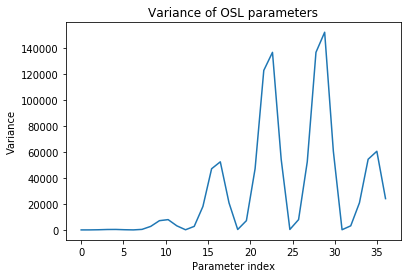

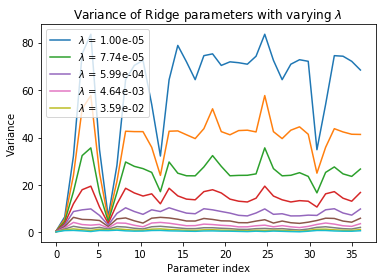

In [3]:
# studying the variance of the OLS and Ridge beta parameters

def beta_variance(X, _lambda):
    XTX = X.T @ X
    var_mat = np.linalg.inv(XTX + _lambda*np.eye(XTX.shape[0], XTX.shape[1])) \
                @ XTX @ np.linalg.inv(XTX \
                + _lambda*np.eye(XTX.shape[0], XTX.shape[1])).T
    
    return np.sqrt(np.diag(var_mat))

# initialize the data and design matrix of polynomial with degree 5
Z_data = regression.make_data().flatten()
X = regression.make_designmatrix(5)

# OLS:
beta_OLS = regression.OSL(Z_data, X)

var_beta_OLS = beta_variance(X, 0)

plt.plot(np.linspace(0, 36, 36), var_beta_OLS)
plt.title("Variance of OSL parameters")
plt.xlabel("Parameter index")
plt.ylabel("Variance")


# Ridge:
_lambda = 0.1
beta_Ridge = regression.Ridge(Z_data, X, _lambda)
XTX = X.T @ X

#var_beta_Ridge = beta_variance(X, )
                       
plt.figure()
for (i, l) in enumerate(np.logspace(-5, -1, 10)):

    if i % 2:
        plt.plot(np.linspace(0, 36, 36), beta_variance(X, l))
    else:
        plt.plot(np.linspace(0, 36, 36), beta_variance(X, l), label="$\lambda$ = %.2e" %l)


plt.title("Variance of Ridge parameters with varying $\lambda$" .format(_lambda))
plt.xlabel("Parameter index")
plt.ylabel("Variance")

plt.legend()

In [2]:
# plotting the Bias-Varianace tradeoff

testing = FrankeFunction_analysis(20, 0.15)

complexity = np.arange(1, 12, 1)
MSE_avg = np.zeros((len(complexity)))
R2_avg = np.copy(MSE_avg)
errors = np.copy(MSE_avg)
bias, variance = np.copy(MSE_avg), np.copy(MSE_avg)

Z_data = testing.make_data().flatten()
for idx, deg in enumerate(complexity):
    variance[idx], bias[idx], errors[idx] = testing.bias_variance(Z_data, deg, 5)
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Model Complexity')
ax1.set_ylabel('Variance', color=color)
ax1.plot(complexity, variance, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Bias^2', color=color)  # we already handled the x-label with ax1
ax2.plot(complexity, bias, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#fig.tight_layout()  # otherwise the right y-label is s
    
"""plt.plot(complexity, variance, label="Variance")
plt.plot(complexity, bias, label="Bias^2", )
plt.plot(complexity, errors, label="Error")
plt.xlabel("Model complexity (polynomial degree)")
plt.ylabel("Wtf")
plt.xticks(complexity)
plt.legend()"""


TypeError: make_designmatrix() missing 2 required positional arguments: 'Y' and 'deg'

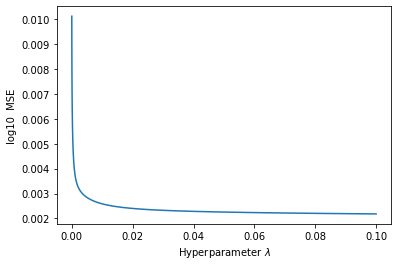

In [7]:
def Ridge_analysis():
    regression = FrankeFunction_analysis(20, 0.15)


    Z_data = regression.make_data().flatten()
    X = regression.make_designmatrix(5)

    MSEs, R2s, betas = regression.kfold_cv_ridge(X, 5, -1)
    lambdas = np.logspace(-1, -5, 100)


    plt.plot(lambdas, MSEs[0,:])

    plt.xlabel("Hyperparameter $\lambda$")
    plt.ylabel("log10  MSE")
    #plt.legend()
    
Ridge_analysis()

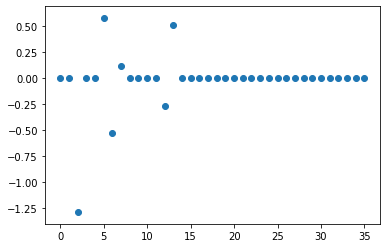

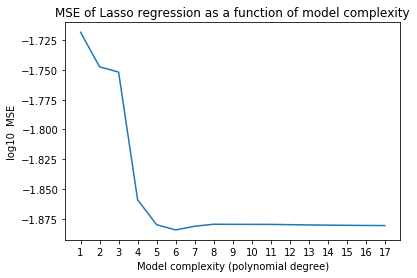

In [10]:
# Lasso analysis
def lasso_analysis():
    
    # initialize the class
    regression_lasso = FrankeFunction_analysis(20, 0.15)

    # array with polynomial degrees
    complexity = np.arange(1, 18, 1)

    # arrays for storing the MSE and R2 score for each polynomial degree
    MSEs = np.zeros(len(complexity))
    R2s = np.copy(MSEs)
    
    
    Z_data = regression_lasso.make_data().flatten()
    for i in range(len(complexity)):
        X = regression_lasso.make_designmatrix(complexity[i])
        Z_tilde, betas = regression_lasso.Lasso(Z_data, X, 0.001)
        MSEs[i] = regression_lasso.MSE(Z_data, Z_tilde)
        if i == 4:
            plt.scatter(np.linspace(0, len(betas)-1, len(betas)), betas)
        
    plt.figure()
    plt.plot(complexity, np.log10(MSEs))
    #plt.plot(complexity, np.log10(R2s), label="Training data")
    plt.xlabel("Model complexity (polynomial degree)")
    plt.ylabel("log10  MSE")
    plt.xticks(complexity)
    plt.title("MSE of Lasso regression as a function of model complexity")
    #plt.legend()

    # with resampling:
    """MSE_avg = np.zeros((2, (len(complexity))))
    R2_avg = np.copy(MSE_avg)

    for i in range(len(complexity)):
        MSE_score, R2_score = regression_lasso.kfold_cv_lasso(complexity[i], 5, -3)
        MSE_avg[0, i] = MSE_score[0, 0]
        R2_avg[0, i] = R2_score[0, 0]

        MSE_avg[1, i] = MSE_score[1, 0]
        R2_avg[1, i] = R2_score[1, 0]

    plt.figure()
    plt.plot(complexity, np.log10(MSE_avg[0]), label="Test data")
    plt.plot(complexity, np.log10(MSE_avg[1]), label="Training data")
    plt.xlabel("Model complexity (polynomial degree)")
    plt.ylabel("log10  MSE")
    plt.xticks(complexity)
    plt.title("Prediction error of training and test data as a function of model complexity")
    plt.legend()"""
    

lasso_analysis()

In [17]:
def test_OLS():
    """A unit test for the self-written OLS regression"""
    
    testing = FrankeFunction_analysis(20, 0.15)
    
    # create target data and design matrix 
    Z_data = testing.make_data().flatten()
    X = testing.make_designmatrix(5)

    """With own OLS:"""
    
    # calculate parameters from self-written OLS and make the prediction
    beta_OSL_test = testing.OSL(Z_data, X)
    Z_tilde_self = X @ beta_OSL_test
    MSE_self = testing.MSE(Z_data, Z_tilde_self)
    
    """With scikit"""
    
    # initialize model and fit data
    model = LinearRegression(fit_intercept=True)
    model.fit(X, Z_data)
    
    # get parameters of model and make the prediction
    beta_OSL_scikit = model.coef_
    #Z_tilde_scikit = X @ beta_OSL_scikit
    Z_tilde_scikit = model.predict(X)
    MSE_scikit = testing.MSE(Z_data, Z_tilde_scikit)

    
    epsilon = 1e-9
    
    np.testing.assert_allclose(Z_tilde_self, Z_tilde_scikit, rtol=epsilon)
    print("OLS model successful to a tolerance of {}" .format(epsilon))
test_OLS()

OLS model successful to a tolerance of 1e-09


# f): introducing real data

Text(0, 0.5, 'Y')

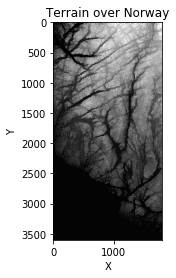

In [42]:
from imageio import imread

terrain = imread("SRTM_data_Norway_2.tif")
plt.figure()
plt.title("Terrain over Norway")
plt.imshow(terrain, cmap="gray")
plt.xlabel("X"); plt.ylabel("Y")


In [44]:
data = terrain.T

def terrain_OLS(data):
    """Perform an OLS analysis of the terrain data"""
    
    OLS_reg = FrankeFunction_analysis(20, 0.15)
    x = np.linspace(0, data.shape[0]-1, data.shape[0])
    y = np.linspace()
    
    # create the design matrix of polynomial degree 5
    X = OLS_reg.make_designmatrix(5)
    
    betas = OLS_reg.OSL(data, X)
    
    data_pred = X @ betas
    
    MSE = OSL_reg.MSE(data, data_pred)
    
    print(MSE)
    
#terrain_OLS(data)

data.shape

(1801, 3601)